In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM, Bidirectional
from keras.utils.np_utils import to_categorical
from keras.utils import np_utils
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import confusion_matrix
import joblib

In [2]:
data_normal_1 = pd.read_csv('dataset/timeseries/dataset_http_timeseries_normal_1.csv')
data_normal_2 = pd.read_csv('dataset/timeseries/dataset_http_timeseries_normal_2.csv')
data_attack_1 = pd.read_csv('dataset/timeseries/dataset_http_timeseries_attack_1.csv')
data_attack_2 = pd.read_csv('dataset/timeseries/dataset_http_timeseries_attack_2.csv')

data_normal_1.columns = ['no_thread', 'connection_time', 'r_bytes', 'port_src', 'status', 'url', 'timeout', 'label']
data_normal_2.columns = ['no_thread', 'connection_time', 'r_bytes', 'port_src', 'status', 'url', 'timeout', 'label']
data_attack_1.columns = ['no_thread', 'connection_time', 'r_bytes', 'port_src', 'status', 'url', 'timeout', 'label']
data_attack_2.columns = ['no_thread', 'connection_time', 'r_bytes', 'port_src', 'status', 'url', 'timeout', 'label']

features = ['no_thread', 'connection_time', 'r_bytes', 'port_src', 'status', 'url', 'timeout']

In [3]:
X_normal_1 = data_normal_1[features].values
X_normal_2 = data_normal_2[features].values
X_attack_1 = data_attack_1[features].values
X_attack_2 = data_attack_2[features].values

Y_normal_1 = data_normal_1['label']
Y_normal_2 = data_normal_2['label']
Y_attack_1 = data_attack_1['label']
Y_attack_2 = data_attack_2['label']

X = np.concatenate((X_normal_1,X_normal_2,X_attack_1,X_attack_2))
Y = np.concatenate((Y_normal_1,Y_normal_2,Y_attack_1,Y_attack_2))

In [4]:
scalar = StandardScaler(copy=True, with_mean=True, with_std=True)
scalar.fit(X)
X = scalar.transform(X)

In [5]:
print(np.shape(X))
print(np.shape(Y))

(10464, 7)
(10464,)


In [6]:
features = len(X[0])
samples = X.shape[0]
train_len = 200
input_len = samples - train_len
I = np.zeros((samples - train_len, train_len, features))

for i in range(input_len):
    temp = np.zeros((train_len, features))
    for j in range(i, i + train_len - 1):
        temp[j-i] = X[j]
    I[i] = temp

print(I.shape)

(10264, 200, 7)


In [7]:
X_train, X_test, Y_train, Y_test = train_test_split(I, Y[200:], test_size = 0.2, stratify=Y[200:], random_state = 0)

In [8]:
def create_baseline():
    model = Sequential()
    model.add(Bidirectional(LSTM(64, activation='tanh', kernel_regularizer='l2')))
    model.add(Dense(128, activation = 'relu', kernel_regularizer='l2'))
    model.add(Dense(1, activation = 'sigmoid', kernel_regularizer='l2'))
    model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
    return model

In [9]:
model = create_baseline()

In [10]:
history = model.fit(X_train, Y_train, epochs = 5,validation_split=0.2, verbose = 1)

Epoch 1/5
206/206 [==============================] - 10s 30ms/step - loss: 0.4988 - accuracy: 0.9913 - val_loss: 0.0650 - val_accuracy: 0.9945
Epoch 2/5
206/206 [==============================] - 5s 27ms/step - loss: 0.0477 - accuracy: 0.9968 - val_loss: 0.0364 - val_accuracy: 0.9982
Epoch 3/5
206/206 [==============================] - 5s 26ms/step - loss: 0.0398 - accuracy: 0.9973 - val_loss: 0.0322 - val_accuracy: 0.9982
Epoch 4/5
206/206 [==============================] - 5s 26ms/step - loss: 0.0372 - accuracy: 0.9976 - val_loss: 0.0310 - val_accuracy: 0.9988
Epoch 5/5
206/206 [==============================] - 6s 27ms/step - loss: 0.0426 - accuracy: 0.9968 - val_loss: 0.0321 - val_accuracy: 0.9988


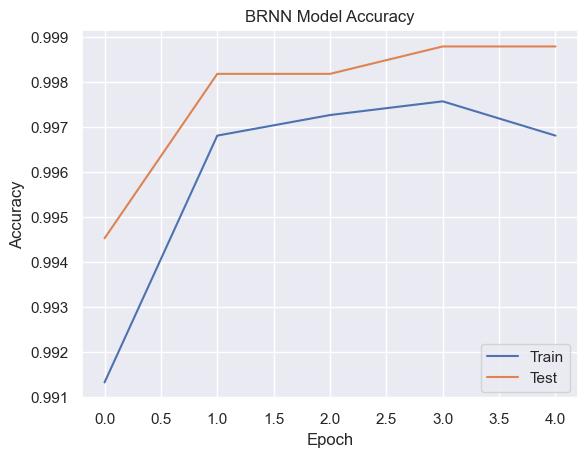

In [11]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('BRNN Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='lower right')
plt.savefig('BRNN Model Accuracy.png')
plt.show()

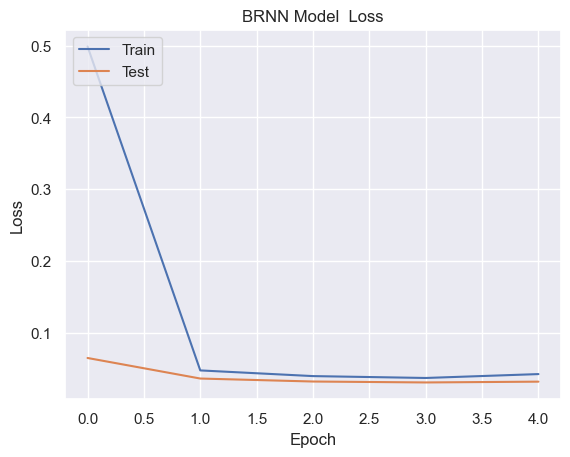

In [12]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('BRNN Model  Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig('BRNN Model Loss.png')
plt.show()

In [13]:
predict = model.predict(X_test, verbose=1)

65/65 [==============================] - 1s 11ms/step


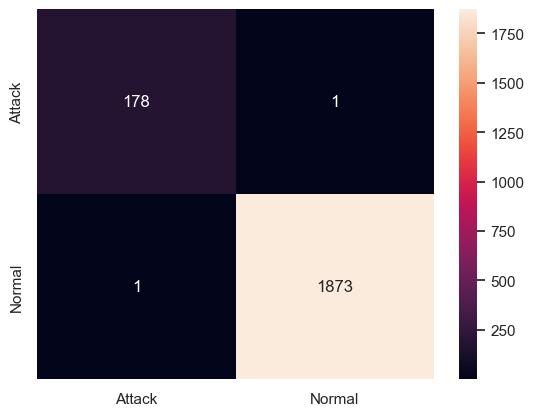

In [14]:
tp = 0
tn = 0
fp = 0
fn = 0
predictn = predict.flatten().round()
predictn = predictn.tolist()
Y_testn = Y_test.tolist()
for i in range(len(Y_testn)):
  if predictn[i]==1 and Y_testn[i]==1:
    tp+=1
  elif predictn[i]==0 and Y_testn[i]==0:
    tn+=1
  elif predictn[i]==0 and Y_testn[i]==1:
    fp+=1
  elif predictn[i]==1 and Y_testn[i]==0:
    fn+=1
to_heat_map =[[tn,fp],[fn,tp]]
to_heat_map = pd.DataFrame(to_heat_map, index = ["Attack","Normal"],columns = ["Attack","Normal"])
ax = sns.heatmap(to_heat_map,annot=True, fmt="d")

figure = ax.get_figure()    
# figure.savefig('confusion_matrix_BRNN.png', dpi=400)

In [15]:
# model.save('brnn_model.h5')
# joblib.dump(scalar, 'scaler.save') 

In [16]:
scores = model.evaluate(X_test, Y_test, verbose=0)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

accuracy: 99.90%
